In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# SWIFT PAT+OBS: Produce figures 3-7 (sections 4.1 and 4.2)

## I/O data

In [2]:
simulations = {
    'case R': 'internal.ipa.wrf',
    'case An': 'internal.ipa.obs.allT',
    'case A1': 'internal.ipa.obs.Tassim',
    'case A0': 'internal.ipa.obs.noT',
}

In [3]:
datadir = '/scratch/dallaert/profile_assimilation_obs'

In [4]:
save_figures = False
figname_prefix = 'results_A'

## Some definitions

In [5]:
hub_height = 90
surface_layer_height = 10

In [6]:
# LOCAL times, from https://www.timeanddate.com/sun/usa/lubbock?month=11&year=2013
sunrise = '2013-11-08 07:12'
sunset  = '2013-11-08 17:49'

In [7]:
wrf_mesoscale_data_file = 'WRF_20131108-09.nc'
tower_10min_data_file = 'TTU_tilt_corrected_20131108-09_10min.csv'
rass_data_file = 'combined_radar_met_sounding_QC.csv'
radar_data_file = 'TTU_obs_QC_20131108.csv'
driving_data_file = 'obs_with_RASSthetav/fieldTable'

## Prepare environment

In [8]:
import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [9]:
# Manually adding path to mmctools repository to PYTHONPATH
sys.path.append(os.path.join(os.environ['HOME'],'pylibs','a2e-mmc'))

from mmctools.mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_timeheight

In [10]:
from helper_functions import sim_style, my_fieldlabels

In [11]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['axes.titlesize']  = 16

## Load simulation data

In [12]:
from helper_functions import calc_QOIs, calc_ablh, calc_surface_QOIs

Load simulation data

In [13]:
%%time
df_10min = {}
for name,sim in simulations.items():
    print('Processing '+name)
    # Read 10min data
    df_10min[name] = xr.open_dataset(os.path.join(datadir,sim,'probe1_10min.nc')).to_dataframe()
    # Calculate some quantities of interest
    calc_QOIs(df_10min[name])

Processing case R
Processing case An
Processing case A1
Processing case A0
CPU times: user 2.24 s, sys: 128 ms, total: 2.37 s
Wall time: 2.57 s


Calculate convective/stable boundary-layer height

In [14]:
ablh = {}
for sim in simulations:
    ablh[sim] = calc_ablh(df_10min[sim])

Calculate surface layer characteristics

In [15]:
df_sl_10min = {}
for sim in simulations:
    df_sl_10min[sim] = calc_surface_QOIs(df_10min[sim],surface_layer_height,100)

Calculate hourly averaged data

In [16]:
df_1h = {}
for sim in simulations:
    df_1h[sim] = df_10min[sim].unstack().resample('1h').mean().stack()

## Load reference data

Reference data:
- **WRF mesoscale:** Data from a WRF mesoscale simulation. NetCDF file generated in [wrf_to_sowfa.ipynb](https://github.com/a2e-mmc/assessment/blob/master/studies/SWiFT/coupling_comparison/preprocessing/internal/wrf_to_sowfa.ipynb)
- **TTU tower (10-min statistics):** Data from the TTU meteorological tower. Dataset generated in [process_TTU_tower.ipynb](https://github.com/a2e-mmc/assessment/blob/master/datasets/SWiFT/process_TTU_tower.ipynb)
- **TTU radar:** Data from the TTU radar profiler. Dataset generated in [process_TTU_radar.ipynb](https://github.com/a2e-mmc/assessment/blob/master/datasets/SWiFT/process_TTU_radar.ipynb)
- **TTU RASS:** Data from the TTU RASS profiler. Dataset generated in [temperature_profile_reconstruction.ipynb](https://github.com/a2e-mmc/assessment/blob/master/datasets/SWiFT/temperature_profile_reconstruction.ipynb)
- **Driving data:** Actual data used to drive the LES, generated in [obs_to_sowfa.ipynb](https://github.com/a2e-mmc/assessment/blob/master/studies/SWiFT/coupling_comparison/preprocessing/internal/obs_to_sowfa.ipynb). This data corresponds to the observational data after gap filling with natural neighbour interpolation

In [17]:
from helper_functions import load_wrf_mesoscale_data, load_TTU_tower_10min_reference_data
from helper_functions import load_TTU_RASS_reference_data, load_TTU_radar_reference_data, load_driving_data

Load reference data

In [18]:
wrf = load_wrf_mesoscale_data(os.path.join(datadir,'referenceData',wrf_mesoscale_data_file))
tower_10min = load_TTU_tower_10min_reference_data(os.path.join(datadir,'referenceData',tower_10min_data_file))
rass = load_TTU_RASS_reference_data(os.path.join(datadir,'referenceData',rass_data_file))
radar_scan0, radar_scan1 = load_TTU_radar_reference_data(os.path.join(datadir,'referenceData',radar_data_file))
driving_data = load_driving_data(os.path.join(datadir,'drivingData',driving_data_file))

Calculate surface layer characteristics

In [19]:
tower_sl = calc_surface_QOIs(tower_10min,surface_layer_height,40)

Calculate hourly averaged data

In [20]:
tower_1h = tower_10min.unstack().resample('1h').mean().stack()
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()
rass_1h = rass.unstack().resample('1h').mean().stack()
wrf_1h = wrf.unstack().resample('1h').mean().stack()

# Generate figures

## Figure 3: Timeheight contour plot

/var/folders/8l/hws4t0354j184hfzbw7n_5mn2f3l4l/T/ipykernel_94948/2806082727.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  axi.set(yticklabels=['0','0.5','1.0','1.5','2.0'],ylabel='Height [km]')


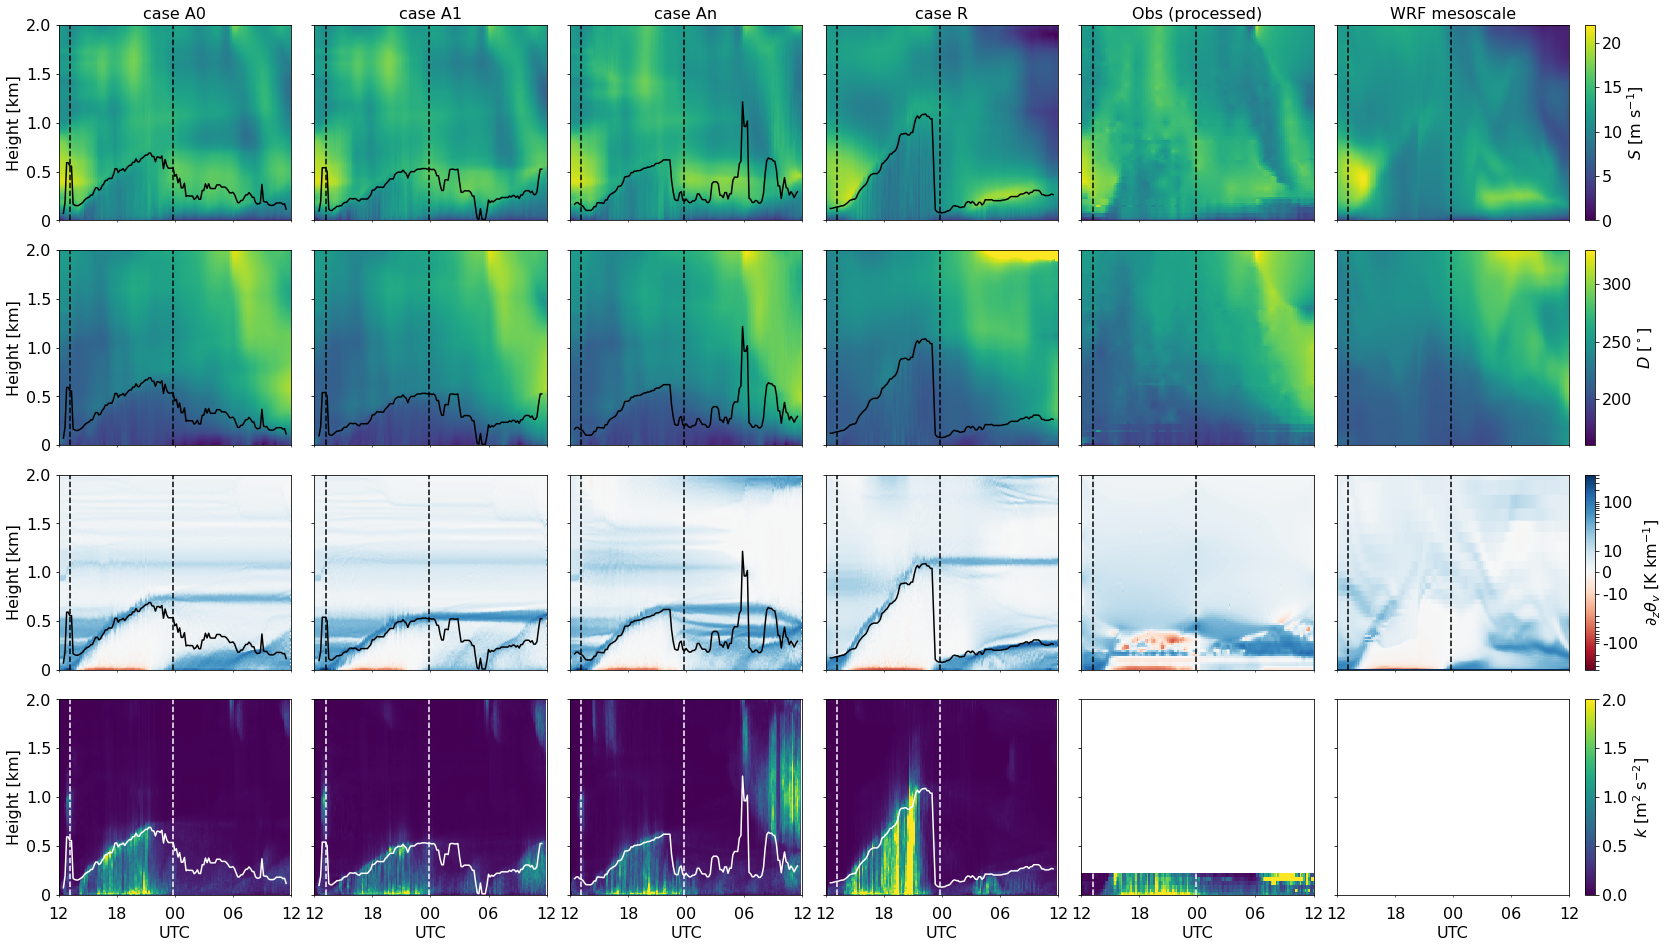

In [21]:
datasets = {
    'case A0': df_10min['case A0'],
    'case A1': df_10min['case A1'],
    'case An': df_10min['case An'],
    'case R': df_10min['case R'],
    'Obs (processed)': driving_data,
    'WRF mesoscale':wrf,
}
cols = len(datasets.keys())
rows = 4

fig,ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=(4.8*cols,4*rows))

figure_settings = {
    'timelimits':('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    'heightlimits':(0,2000),
    'rasterized':True,
    'shading':'flat',
    'showcolorbars':False,
    'fig':fig,
}

# Manual adjustment to make wind direction near top of the domain cyclic
wdir = df_10min['case R']['wdir']
wdir[(wdir.index.get_level_values(1)>1750) & (wdir<160)] += 360
df_10min['case R']['wdir'] = wdir

for col, sim in enumerate(datasets):
    _,_,cbars = plot_timeheight(
        datasets[sim],
        fields=['wspd','wdir'],
        fieldlimits={'wspd':(0,22),'wdir':(160,330)},
        colorschemes={'wdir':'viridis'},
        ax=ax[:2,col],
        **figure_settings,
    )
    _,_,cbars = plot_timeheight(
        datasets[sim],
        fields='thetav_gradient',
        fieldlimits=(-500,500),
        colorschemes='RdBu',
        ax=ax[2,col],
        **figure_settings,
        norm=mpl.colors.SymLogNorm(linthresh=20, linscale=1, vmin=-500, vmax=500, base=10),
        vmin=None,vmax=None #Explicitly set these to None for backward compatibility
    )
    if sim not in ['Obs (processed)', 'WRF mesoscale']:
        _,_,cbars = plot_timeheight(
            datasets[sim],
            fields='TKE',
            fieldlimits=(0,2),
            colorschemes='viridis',#'magma',
            ax=ax[3,col],
            **figure_settings,
        )
        ax[0,col].plot(ablh[sim].index, ablh[sim], color='black')
        ax[1,col].plot(ablh[sim].index, ablh[sim], color='black')
        ax[2,col].plot(ablh[sim].index, ablh[sim], color='black')
        ax[3,col].plot(ablh[sim].index, ablh[sim], color='white')
    elif sim=='Obs (processed)':
        _,_,cbars = plot_timeheight(
            tower_10min,
            fields='TKE',
            fieldlimits=(0,2),
            colorschemes='viridis',#'magma',
            ax=ax[3,col],
            **figure_settings,
        )
    ax[0,col].set(title=sim)

fig.subplots_adjust(wspace=0.1,hspace=0.15)

for axi in np.asarray(ax[:-1,:]).ravel():
    axi.axvline(pd.to_datetime(sunrise)+ pd.to_timedelta('6h'),color='k',ls='--')
    axi.axvline(pd.to_datetime(sunset)+ pd.to_timedelta('6h'),color='k',ls='--')
for axi in np.asarray(ax[-1,:]).ravel():
    axi.axvline(pd.to_datetime(sunrise)+ pd.to_timedelta('6h'),color='white',ls='--')
    axi.axvline(pd.to_datetime(sunset)+ pd.to_timedelta('6h'),color='white',ls='--')
    
#Rescale yaxis
for axi in np.asarray(ax[:,0]).ravel():
    axi.set(yticklabels=['0','0.5','1.0','1.5','2.0'],ylabel='Height [km]')

#Hide ylabels
for axi in np.asarray(ax[:,1:]).ravel():
    axi.set(ylabel='')
    
#Hide xlabels
for axi in np.asarray(ax).ravel():
    axi.set(xlabel='')

# Adjust xaxis tick locations
ax[0,0].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=6))
ax[0,0].xaxis.set_minor_formatter(mdates.DateFormatter('%H')) #%H%M
ax[0,0].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

# Add colorbars to last column
cbar = plt.colorbar(ax[0,0].collections[-1],ax=ax[0,:],fraction=0.05, pad=0.01)
cbar.set_label(my_fieldlabels['wspd'])
cbar = plt.colorbar(ax[1,0].collections[-1],ax=ax[1,:],fraction=0.05, pad=0.01)
cbar.set_label(my_fieldlabels['wdir'])
cbar = plt.colorbar(ax[2,0].collections[-1],ax=ax[2,:],fraction=0.05, pad=0.01)
cbar.set_label(r'$\partial_z \theta_v$ [K km$^{-1}$]')
#Manually set ticks
labels = ['']*29
labels[0]='0'
labels[1]='-10'
labels[2]='10'
labels[19]='-100'
labels[20]='100'
ticks = [0]+[10*x for i in range(1,10) for x in (-i,i)]+[100*x for i in range(1,6) for x in (-i,i)]
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

cbar = plt.colorbar(ax[3,0].collections[-1],ax=ax[3,:],fraction=0.05, pad=0.01)
cbar.set_label(my_fieldlabels['TKE'])

#Move xs tick down slightly to avoid overlap with y ticks
for axi in np.asarray(ax[-1,:]).ravel():
    axi.tick_params(axis='x', which='minor', pad=10)
    axi.tick_params(axis='x', which='major', pad=10)
    axi.set_xticks([]) # Hide date on local time axis (BLM edits)
    axi.set_xlabel('UTC')

#Save figure
if save_figures:
    figname = figname_prefix+'_timeheight_contour'
    plt.savefig(os.path.join('Figures',figname+'.png'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.eps'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.pdf'),bbox_inches='tight')

## Figure 4: Time history at hub height

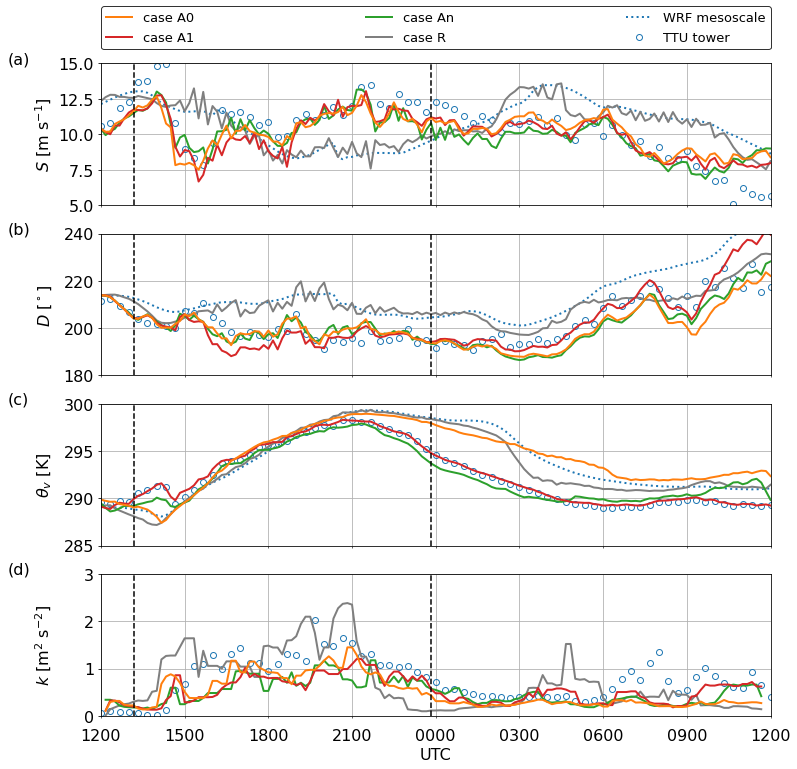

In [22]:
fig,ax = plot_timehistory_at_height(
    datasets={
        'TTU tower': tower_10min,
        'WRF mesoscale': wrf,
        **df_10min
    },
    fields = ['wspd','wdir','thetav','TKEf'],
    heights = hub_height,
    fieldlimits={
        'wspd':(5.,15.),
        'wdir':(180,240),
        'thetav':(285,300),
        'TKEf':(0,3)
    },
    fieldlabels=my_fieldlabels,
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    #plot_local_time='%H%M',local_time_offset=-6,
    labelsubplots=True,
    datasetkwargs={
        #'TTU tower':{'linestyle':'-','color':'tab:blue','linewidth':2},
        'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'tab:blue','markevery':2},
        **sim_style
    },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

for axi in ax:
    axi.axvline(pd.to_datetime(sunrise)+ pd.to_timedelta('6h'),color='k',ls='--')
    axi.axvline(pd.to_datetime(sunset)+ pd.to_timedelta('6h'),color='k',ls='--')

#Place legend at the top
handles, labels = ax[0].get_legend_handles_labels()


leg = ax[0].legend(handles[-1::-1],labels[-1::-1],loc='lower left',bbox_to_anchor=(0.0,1.1,1.0,0.0),
             borderaxespad=0,fontsize=13,ncol=3,mode='expand')
leg.get_frame().set_edgecolor('k')

# Adjust xaxis tick locations
ax[-1].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=3))
ax[-1].xaxis.set_minor_formatter(mdates.DateFormatter('%H%M'))
ax[-1].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)
ax[-1].tick_params(axis='x', which='major', pad=10)
ax[-1].set_xticks([])
ax[-1].set_xlabel('UTC')


#Save figure
if save_figures:
    figname = figname_prefix+'_mean_timehistory'
    plt.savefig(os.path.join('Figures',figname+'.png'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.eps'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.pdf'),bbox_inches='tight')

## Figure 5: Time history of surface layer characteristics

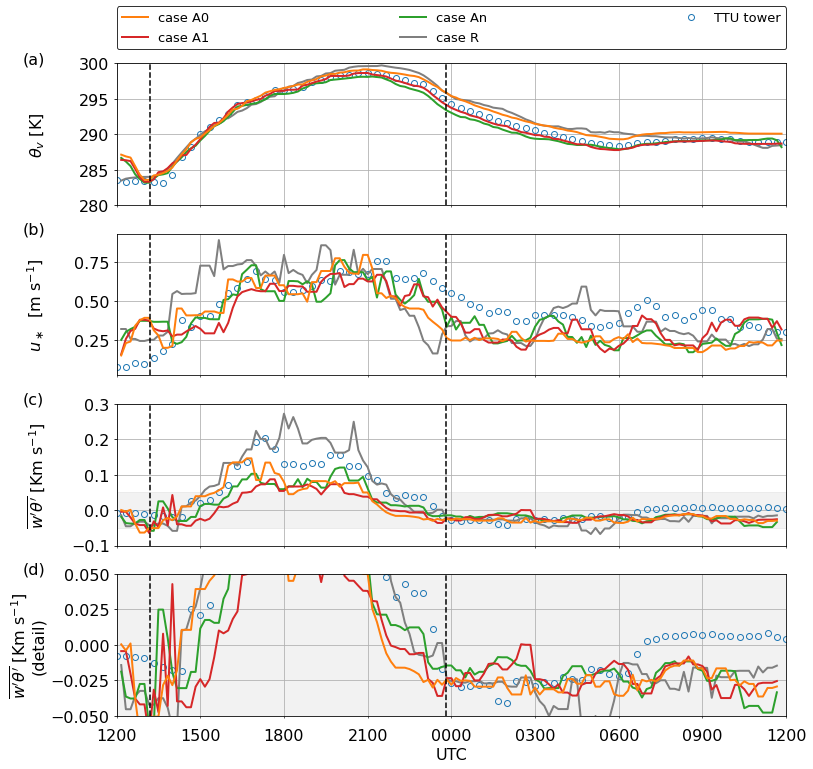

In [23]:
fig,ax = plot_timehistory_at_height(
    datasets={
        'TTU tower': tower_sl,
        **df_sl_10min
    },
    fields = ['thetav','u*','thetaw','thetaw_zoom'],
    fieldlimits={
        'thetav':(280,300),
        'thetaw':(-0.1,0.3),
        'thetaw_zoom':(-0.05,0.05),
    },
    fieldlabels={
        'u*':r'$u_\ast$  [m s$^{-1}$]',
        'thetaw_zoom':r'$\overline{w^\prime \theta^\prime}$ [Km s$^{-1}$]'+'\n(detail)',
        **my_fieldlabels
    },
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    #plot_local_time=True,
    #local_time_offset=-6,
    labelsubplots=True,
    datasetkwargs={
        #'TTU tower':{'linestyle':'-','color':'tab:blue','linewidth':2},
        'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'tab:blue','markevery':2},
        **sim_style
    },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

ax[2].fill_between(['2013-11-08 12:00:00','2013-11-09 12:00:00'],[-0.05,-0.05],[0.05,0.05],alpha=0.1,color='gray')
ax[3].fill_between(['2013-11-08 12:00:00','2013-11-09 12:00:00'],[-0.05,-0.05],[0.05,0.05],alpha=0.1,color='gray')

for axi in ax:
    axi.axvline(pd.to_datetime(sunrise)+ pd.to_timedelta('6h'),color='k',ls='--')
    axi.axvline(pd.to_datetime(sunset)+ pd.to_timedelta('6h'),color='k',ls='--')

#Place legend at the top
handles, labels = ax[0].get_legend_handles_labels()


leg = ax[0].legend(handles[-1::-1],labels[-1::-1],loc='lower left',bbox_to_anchor=(0.0,1.1,1.0,0.0),
             borderaxespad=0,fontsize=13,ncol=3,mode='expand')
leg.get_frame().set_edgecolor('k')

# Adjust xaxis tick locations
ax[-1].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=3))
ax[-1].xaxis.set_minor_formatter(mdates.DateFormatter('%H%M'))
ax[-1].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)
ax[-1].tick_params(axis='x', which='major', pad=10)
ax[-1].set_xticks([])
ax[-1].set_xlabel('UTC')

#Save figure
if save_figures:
    figname = figname_prefix+'_surface_QoI_zoom'
    plt.savefig(os.path.join('Figures',figname+'.png'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.eps'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.pdf'),bbox_inches='tight')

## Figure 6: Mean profiles

/var/folders/8l/hws4t0354j184hfzbw7n_5mn2f3l4l/T/ipykernel_94948/422473387.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axi.set(yticklabels=['0','0.5','1.0','1.5','2.0'],ylabel='Height [km]')


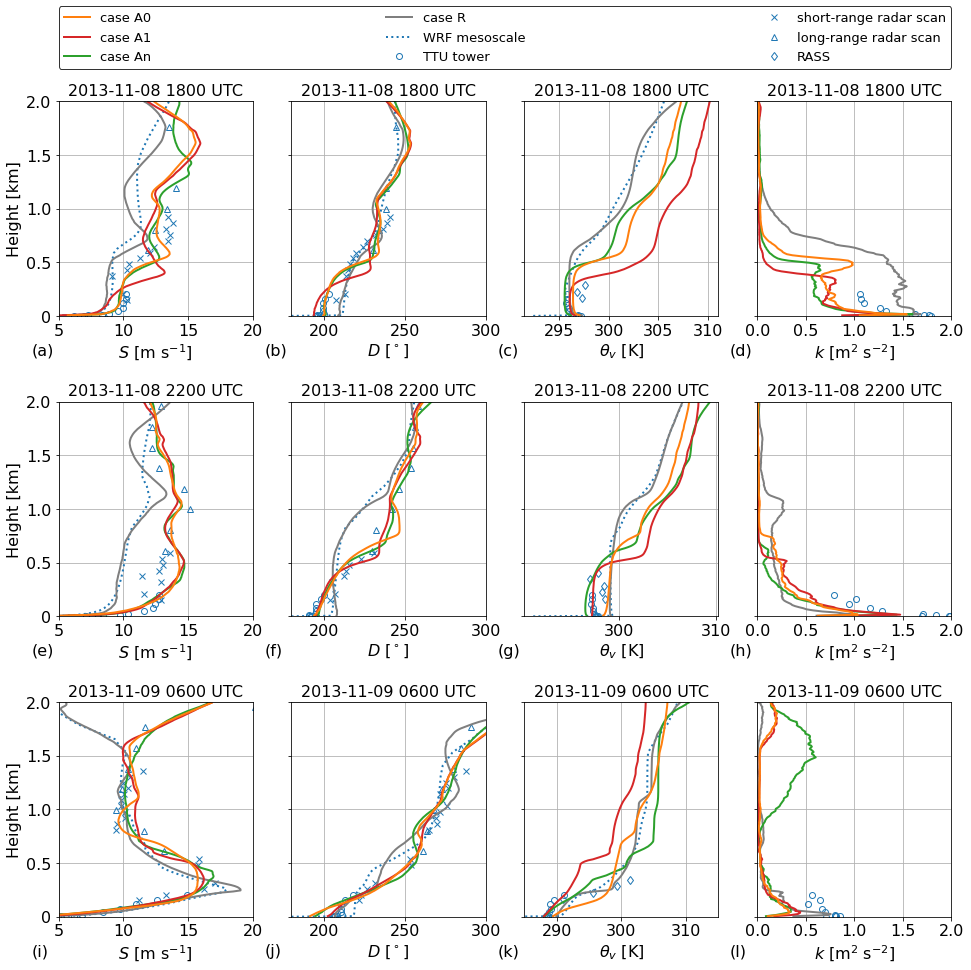

In [24]:
fig,ax = plot_profile(
    datasets={
        'long-range radar scan':radar_scan1_1h,
        'short-range radar scan':radar_scan0_1h,
        'RASS':rass_1h,
        'TTU tower': tower_1h,
        'WRF mesoscale': wrf_1h,
        **df_1h
    },
    fields=['wspd','wdir','thetav','TKE'],
    fieldlimits={
        'wspd':(5.,20.),
        'wdir':(180,300),
        'theta':(290,310),
        'TKE':(0,2)
    },
    fieldlabels=my_fieldlabels,
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    # Specify height limits
    heightlimits=(0,2000),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'tab:blue'},
                   'short-range radar scan':{'linestyle':'','marker':'x','mfc':'none','markersize':6,'color':'tab:blue'},
                   'long-range radar scan':{'linestyle':'','marker':'^','mfc':'none','markersize':6,'color':'tab:blue'},
                   'RASS':{'linestyle':'','marker':'d','mfc':'none','markersize':6,'color':'tab:blue'},
                   **sim_style
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
    labelsubplots=True,
)

# Set temperature limits
ax[2,2].set_xlim([285,315])

#Rescale yaxis
for axi in np.asarray(ax[:,0]).ravel():
    axi.set(yticklabels=['0','0.5','1.0','1.5','2.0'],ylabel='Height [km]')

#Place legend at the top
handles, labels = ax[0,0].get_legend_handles_labels()
Thandles, Tlabels = ax[2,2].get_legend_handles_labels() # legend entry for Temperature
ax[0,3].get_legend().remove()

for (handle,label) in zip(Thandles,Tlabels):
    if label not in labels:
        labels.insert(0,label)
        handles.insert(0,handle)


leg = fig.legend(handles[-1::-1], labels[-1::-1], loc = 'lower left', bbox_to_anchor = (.125,.91,.775,0.0),
         borderaxespad=0,ncol=3,fontsize=13,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')


#Save figure
if save_figures:
    figname = figname_prefix+'_mean_profiles'
    plt.savefig(os.path.join('Figures',figname+'.png'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.eps'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.pdf'),bbox_inches='tight')

In [25]:
#Jet nose height
for sim in simulations:
    print(
        sim,
        df_1h[sim].loc[df_1h[sim].index.get_level_values(1)<1000].xs('2013-11-09 06:00',level=0)['wspd'].idxmax(),
        df_1h[sim].loc[df_1h[sim].index.get_level_values(1)<1000].xs('2013-11-09 06:00',level=0)['wspd'].max()
    )
print(
    'WRF',
    wrf_1h.loc[wrf_1h.index.get_level_values(1)<1000].xs('2013-11-09 06:00',level=0)['wspd'].idxmax(),
    wrf_1h.loc[wrf_1h.index.get_level_values(1)<1000].xs('2013-11-09 06:00',level=0)['wspd'].max()
)

case R 245.001 19.062875053055993
case An 375.001 16.97723176192784
case A1 355.001 16.222560473674726
case A0 355.001 15.760500516414636
WRF 255.0 17.97148176628043


## Figure 7: Flux profiles

/var/folders/8l/hws4t0354j184hfzbw7n_5mn2f3l4l/T/ipykernel_94948/1707933645.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axi.set(yticklabels=['0','0.5','1.0','1.5','2.0'],ylabel='Height [km]')


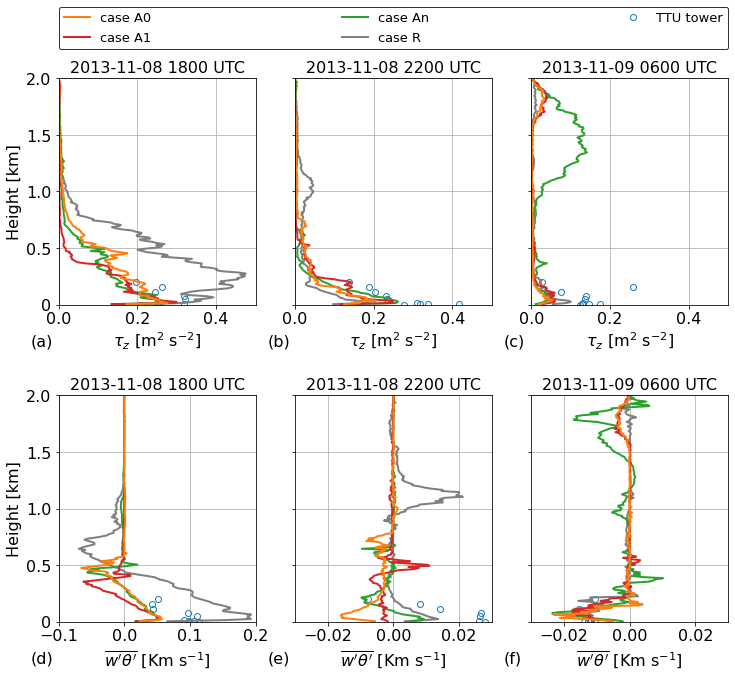

In [26]:
fig,ax = plot_profile(
    datasets={
        'TTU tower': tower_1h,
        **df_1h
    },
    fields=['tauz','thetaw'],
    fieldlimits={
        'tauz':(0,0.5),
        #'thetaw':(-0.05,0.2),
    },
    fieldlabels=my_fieldlabels,
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    # Specify height limits
    heightlimits=(0,2000),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'tab:blue'},
                   **sim_style
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
    labelsubplots=True,
)

ax[1,0].set_xlim([-0.1,0.2])
ax[1,1].set_xlim([-0.03,0.03])
ax[1,2].set_xlim([-0.03,0.03])

#Rescale yaxis
for axi in np.asarray(ax[:,0]).ravel():
    axi.set(yticklabels=['0','0.5','1.0','1.5','2.0'],ylabel='Height [km]')

#Place legend at the top
handles, labels = ax[0,0].get_legend_handles_labels()
ax[0,2].get_legend().remove()


leg = fig.legend(handles[-1::-1], labels[-1::-1], loc = 'lower left', bbox_to_anchor = (.125,.92,.775,0.0),
         borderaxespad=0,ncol=3,fontsize=13,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')


#Save figure
if save_figures:
    figname = figname_prefix+'_flux_profiles'
    plt.savefig(os.path.join('Figures',figname+'.png'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.eps'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.pdf'),bbox_inches='tight')